In [1]:
import sys
sys.path.append('/home/achint/Generative_Modelling/POISEVAE-master')
import os, copy, time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
import poisevae
from poisevae.utils import CategoricalImage as Categorical
from poisevae.datasets import MNIST_MNIST
from poisevae.networks.MNISTMNISTNetworks_X import EncMNIST1, DecMNIST1, EncMNIST2, DecMNIST2
from poisevae.networks.MNISTMNISTNetworks_pixelcnn import pixelcnn_decoder
# from poisevae.networks.conv_layers import MaskedConv2d, CroppedConv2d
from poisevae.networks.model import PixelCNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
MNIST_PATH = "/home/achint/datasets/MNIST/%s.pt"
SVHN_PATH = "/home/achint/datasets/SVHN/%s_32x32.mat"

joint_dataset_train = MNIST_MNIST.MNIST_MNIST(mnist_pt_path_1=MNIST_PATH % 'training', mnist_pt_path_2=MNIST_PATH % 'training')
joint_dataset_test  = MNIST_MNIST.MNIST_MNIST(mnist_pt_path_1=MNIST_PATH % 'test', mnist_pt_path_2=MNIST_PATH % 'test')

In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(468, 78)

In [4]:
def loss_function(x_rec, x):
    x_rec = x_rec.flatten(-3,-1)#.flatten(0, 1)
    color_level = 256
    x = (x * (color_level - 1)).floor()#.long()
    x_ = torch.zeros_like(x_rec)#.long()
    for i in range(x_rec.shape[0]):
        x_[i, :] = x[i].unsqueeze(0)
    
    print(x_rec.shape, x_.shape)
    x_rec = x_rec.flatten(0, 1)
    x_ = x_.flatten(0, 1)
    
    ce_loss = nn.CrossEntropyLoss(reduction='none')
    print(x_rec.shape, x_.shape)
    MSE = ce_loss(x_rec,x_).sum(dim=-1)
    print(MSE.shape)
    return MSE

In [5]:
lat1, lat2 = 20, 20
enc_mnist1 = EncMNIST1(lat1, lat2).to(device)
enc_mnist2 = EncMNIST2(lat1, lat2).to(device)

dec_mnist1 = pixelcnn_decoder(PixelCNN(lat1, 1)).to(device)
dec_mnist2 = pixelcnn_decoder(PixelCNN(lat1, 1)).to(device)

# Options: 'autograd' and 'gradient'
vae = poisevae.POISEVAE_Gibbs('gradient',
                              [enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], likelihoods=[Categorical, Categorical],
                              latent_dims=[lat1, (lat2)], enc_config='nu', KL_calc='derivative', 
                              batch_size=batch_size, reduction='mean'
                             ).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
writer = None

In [6]:
PATH = '/home/achint/runs'
epoch = 0
epochs = 1 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, 3, 2, writer, img=torch.zeros(batch_size * 2, 784), generate_mode=False)
    poisevae.utils.test(vae, test_loader, epoch, 3, 2, writer, img=torch.zeros(batch_size * 2, 784), generate_mode=False)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

mu max: 0.1710960417985916 mu mean: 0.054128944873809814
mup max: 0.15611562132835388 mup mean: 0.053411778062582016
var min: 0.865181565284729 var mean: 0.978986382484436
varp min: 0.8572289347648621 varp mean: 1.021112322807312
torch.Size([128, 1, 784]) torch.Size([128, 2, 784, 256])
torch.Size([128, 1, 784]) torch.Size([128, 2, 784, 256])
total loss: 8607.43359375 kl term: 0.0
rec1 loss: 4461.6474609375 rec2 loss: 4145.78564453125

dG11 Rec 0.37233588099479675 dG12 Rec 0.205005943775177
dG21 Rec 0.14155030250549316 dG22 Rec 0.06783679127693176
dnu1 Rec 1.0313955545425415 dnu2 Rec 0.3701983392238617
dnu1p Rec 1.4493590593338013 dnu2p Rec 0.7400562167167664
dG11 KL 0.19684559106826782 dG12 KL 0.10895249992609024
dG21 KL 0.07582633197307587 dG22 KL 0.037154391407966614
dnu1 KL 0.5311225056648254 dnu2 KL 0.19833515584468842
dnu1p KL 0.7511500716209412 dnu2p KL 0.3984381854534149
mu max: 0.18890856206417084 mu mean: 0.06407041102647781
mup max: 0.19766727089881897 mup mean: 0.05451223254

100%|████████████████████████████████████████████| 1/1 [04:09<00:00, 249.34s/it]

torch.Size([128, 1, 784]) torch.Size([128, 2, 784, 256])
torch.Size([128, 1, 784]) torch.Size([128, 2, 784, 256])
total loss: 1887.393798828125 kl term: 0.0
rec1 loss: 945.0732421875 rec2 loss: 942.3204956054688



In [7]:
poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

In [8]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],img=torch.zeros(batch_size * 2, 784), generate_mode=False, n_gibbs_iter=2)
        break

mu max: 5.466224670410156 mu mean: 0.8170391321182251
mup max: 2.244429588317871 mup mean: 0.25064870715141296
var min: 1.032568519576671e-07 var mean: 0.012985791079699993
varp min: 5.940735718468204e-05 varp mean: 0.03675193339586258
torch.Size([128, 1, 784]) torch.Size([128, 2, 784, 256])
torch.Size([128, 1, 784]) torch.Size([128, 2, 784, 256])
total loss: 1915.3037109375 kl term: 0.0
rec1 loss: 958.2972412109375 rec2 loss: 957.0064697265625



In [9]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].probs, x_rec[1].probs]
    # idx = torch.where(results['weights'] == results['weights'].max(dim=1).values[:, None])
    # x_rec = [x_rec[0].loc[idx], x_rec[1].loc[idx]] # (batch, IW samples, ...)

In [10]:
x_rec = [x_rec[0].max(dim=-1).indices.squeeze()[:, -1],x_rec[1].max(dim=-1).indices.squeeze()[:, -1]]
x_rec[0].shape

torch.Size([128, 784])

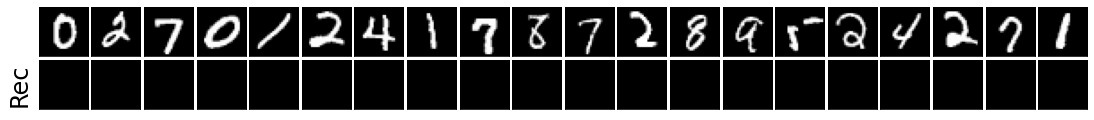

In [11]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

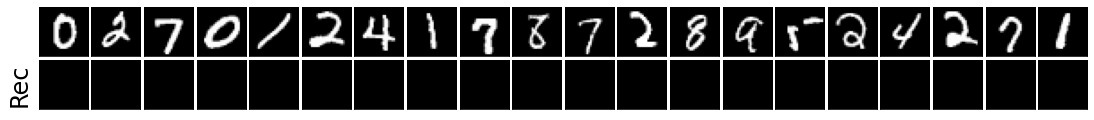

In [13]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [12]:
x_rec[1].shape

torch.Size([128, 784])